In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

C:\Users\JingYou\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "10:30:00"
NUM_CLUSTER = 50
TIME_STEP = 5

In [216]:
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
# def load_data(date_begin='20180612', date_end = '20180730', split_date_begin = '20180801', split_date_end = '20180830', train = True):

    X = []
    Y = []
    h1, m1, s1 = [int(x) for x in BEGIN_TIME.split(":")]
    h2, m2, s2 = [int(x) for x in END_TIME.split(":")]
    t1 = dt.timedelta(hours = h1, minutes=m1)
    t2 = dt.timedelta(hours = h2, minutes=m2)
    total_mins = (t2-t1).total_seconds()//60
    
    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "close"]
                if len(front_df) == (90 // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

def dtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
    return d

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_d)

def fastdtw_d(X, Y):
    return fastdtw(X, Y, dist=euclidean)[0]

def fastdtw_affinity(X):
    return pairwise_distances(X, metric=fastdtw_d)
def show_clustering():
    for n in range(NUM_CLUSTER):
        plt.title(n)
        for i in range(len(X)):
        #     plt.subplot(10, 1, X_label[i]+1)
            if X_label[i] == n:
                plt.plot(X[i])
        plt.show()
def train(max_iter = 300, n_clusters = 50):
    t1 = time.time()
    km = TimeSeriesKMeans(max_iter = max_iter, n_clusters=n_clusters, metric="dtw", n_jobs=5)
    X_label = km.fit_predict(X)
    t2 = time.time()
    print("training time", t2-t1)
    return km

def make_long_simple(y, cost):
    return y.max(),   y[0] * (1 + cost)
def make_short_simple(y, cost):
    return y[0], y.min() * (1 + cost)
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0], - y.max() - cost
def make_long(y, cost, exp_profit):
    if (y- (y[0] * (1+cost)) >= exp_profit).any():
        return y[0] *( 1 + exp_profit),   y[0] * (1 + cost)
    else:
        return y[-1],   y[0] * (1 + cost)
def make_short(y, cost, exp_profit):
    if (y[0] - y >=  y[0] * (exp_profit + cost)).any():
        return y[0] * (1-cost), y[0] * (1-exp_profit) 
    else:
        return y[0] * (1-cost), y[-1]
    
def evaluate_km(X_test, Y_test, X_label, exp_profit=0.025):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    cost_long_array = np.zeros(NUM_CLUSTER)
    cost_short_array = np.zeros(NUM_CLUSTER)
    num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
    #     p, l = make_long_simple(Y[i], 0.002)
    #     profit_long_array[X_label[i]] += p
    #     cost_short_array[X_label[i]] += l
        p, l = make_short(Y_test[i], 0.002, exp_profit)
        profit_short_array[X_label[i]] += p
        cost_short_array[X_label[i]] += l
        num_exchange_array[X_label[i]] += 1

    return profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array

In [204]:
y = Y[2]

In [205]:
exp_profit = 0.025
cost = 0.002

In [206]:
y[0] - y

array([  0.,  -2.,  -2.,  -7.,  -3.,  -2.,  -1.,  -3.,   0.,   6.,   8.,
         5.,   8.,   8.,   8.,   7.,   7.,   7.,  10.,  15.,  18.,  20.,
        23.,  23.,  24.,  24.,  25.,  27.,  26.,  27.,  30.,  28.,  27.,
        23.,  23.,  21.,  17.,  21.,  19.,  15.,   9.,  10.,   8.,  10.,
        11.,  11.,  11.,   5.,   5.,   1.,   0.,  -7.,  -7.,  -5.,  -3.,
        -5.,  -4.,  -4.,  -3.,  -7.,  -9., -10., -11.,  -8.,  -6.,  -8.,
        -7.,  -6.,  -7.,  -7.,  -7.,  -6.,  -4.,   0.,  -2.,  -4.,  -3.,
        -5.,  -6., -10.,  -6., -10., -12., -17., -19., -22., -21., -21.,
       -18., -23., -24., -25., -28., -31., -31., -29., -31., -34., -37.,
       -37., -42., -52., -42., -42., -47., -47., -42., -42., -42., -42.,
       -42., -42., -42., -42., -37., -47., -52., -47., -52., -57., -57.,
       -57., -57., -52., -52., -47., -47., -47., -42., -37., -42., -42.,
       -42., -47., -47., -52., -47., -47., -47., -42., -47., -47., -42.,
       -42., -42., -42., -37., -37., -42., -42., -4

In [207]:
y[0] * (exp_profit+cost)

26.001000000000005

In [208]:
y = Y[1]

In [172]:
y[0]*(1-0.025)

1111.5

In [183]:
make_short(Y[0], 0.02, 0.04)

(1117.2, 1135.0)

In [129]:
X, Y = load_data()

100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


In [130]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


In [7]:
print(X.shape)

(2990, 19)


In [8]:
print(X_test.shape)

(915, 19)


t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [107]:
km = train()

training time 175.69941186904907


t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [9]:
t1 = time.time()
km = TimeSeriesKMeans(n_clusters=50, metric="dtw", n_jobs=5)
X_label = km.fit_predict(X)
t2 = time.time()
print("time", t2-t1)

time 228.74551129341125


t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [149]:
X_label

array([20, 25, 20, ...,  3, 17, 11], dtype=int64)

pickle.dump(X, open(os.path.join('dataset_pk',"X_ts.pk"), "wb"))
pickle.dump(Y, open(os.path.join('dataset_pk',"Y_ts.pk"), "wb"))


In [211]:
# show_clustering()

def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open(os.path.join('dataset_pk',"X_ts_tabel.pk"), "wb"))

In [31]:
len(X)

2990

In [132]:
Y.shape

(2990,)

pickle.dump(km, open("km.pk", 'wb'))

km = pickle.load(open("km.pk", 'rb'))

km = pickle.load(open("km.pk", 'rb'))
X = pickle.load(open(os.path.join('dataset_pk',"X_ts.pk"), 'rb'))
Y = pickle.load(open(os.path.join('dataset_pk',"Y_ts.pk"), 'rb'))
X_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))
Y_test = pickle.load(open(os.path.join('dataset_pk',"X_test.pk"), 'rb'))

X_label = km.predict(X)

X_label

In [222]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
cost_long_array = np.zeros(NUM_CLUSTER)
cost_short_array = np.zeros(NUM_CLUSTER)
num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    p, l = make_short(Y[i], 0.002, 0.01)
    profit_short_array[X_label[i]] += p
    cost_short_array[X_label[i]] += l
    num_exchange_array[X_label[i]] += 1
print("0.025" ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])
best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]

# profit_long_array = np.zeros(NUM_CLUSTER)
# profit_short_array = np.zeros(NUM_CLUSTER)
# cost_long_array = np.zeros(NUM_CLUSTER)
# cost_short_array = np.zeros(NUM_CLUSTER)
# num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")

# for i in range(len(X)):
#     p, l = make_short(Y[i], 0.002, 0.02)
#     profit_short_array[X_label[i]] += p
#     cost_short_array[X_label[i]] += l
#     num_exchange_array[X_label[i]] += 1
# print('0.02' ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])

# profit_long_array = np.zeros(NUM_CLUSTER)
# profit_short_array = np.zeros(NUM_CLUSTER)
# cost_long_array = np.zeros(NUM_CLUSTER)
# cost_short_array = np.zeros(NUM_CLUSTER)
# num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")

# for i in range(len(X)):
#     p, l = make_short(Y[i], 0.002, 0.025)
#     profit_short_array[X_label[i]] += p
#     cost_short_array[X_label[i]] += l
#     num_exchange_array[X_label[i]] += 1
# print('0.025' ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])

# profit_long_array = np.zeros(NUM_CLUSTER)
# profit_short_array = np.zeros(NUM_CLUSTER)
# cost_long_array = np.zeros(NUM_CLUSTER)
# cost_short_array = np.zeros(NUM_CLUSTER)
# num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")

# for i in range(len(X)):
#     p, l = make_short(Y[i], 0.002, 0.03)
#     profit_short_array[X_label[i]] += p
#     cost_short_array[X_label[i]] += l
#     num_exchange_array[X_label[i]] += 1
# print('0.03' ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])
# best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]

# profit_long_array = np.zeros(NUM_CLUSTER)
# profit_short_array = np.zeros(NUM_CLUSTER)
# cost_long_array = np.zeros(NUM_CLUSTER)
# cost_short_array = np.zeros(NUM_CLUSTER)
# num_exchange_array = np.zeros(NUM_CLUSTER).astype("int")

# for i in range(len(X)):
#     p, l = make_short(Y[i], 0.002, 0.04)
#     profit_short_array[X_label[i]] += p
#     cost_short_array[X_label[i]] += l
#     num_exchange_array[X_label[i]] += 1
# print('0.04' ,sorted((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1][:10])
# best_short_cluster = np.argsort((profit_short_array-cost_short_array)/profit_short_array/num_exchange_array)[::-1]


0.025 [0.0013360053440213742, 0.0003198584222908367, 0.00015783863790756503, 0.00012885171260344446, 7.157949777640068e-05, 7.099743942510306e-05, 4.3680025119398784e-05, 1.4522579632451548e-05, 9.786305983125142e-06, 8.681374106212333e-06]


In [223]:
print(best_short_cluster)

[15 46 47 20 49  4 18 19 21 43 25 10 41  7 11 44 39 26 35  3  0 40 31  2
 27 32 13  6 22 17 23 38 16 30 24 33  5 14  1  8 29 45 36 34 42 48 28  9
 37 12]


In [45]:
Y_pred = km.predict(X.reshape(len(X), len(X[0]), 1))

In [146]:
y_test_pred =  km.predict(X_test.reshape(len(X_test), len(X_test[0]), 1))

In [219]:
profit_short_array

array([25157.9333, 12322.8549,  3084.2192, 12558.7322,  3901.7309,
       14635.9195, 13973.3473, 27452.3353,  4786.408 ,   208.582 ,
       29376.8785, 14372.198 ,   134.231 , 22816.3259,  8228.1607,
        1143.209 , 12579.291 , 13999.0458,  5744.987 , 10393.5213,
        4198.7357,  3341.4038, 21721.4201,  7727.9132, 15105.2789,
        8348.8189, 27827.4835,  9734.6417,  4776.7274, 11281.0427,
        5048.6325, 28193.5   ,  7353.8628,  8192.4822,  2428.7827,
       12689.1209,  3951.5311,  1314.366 , 15071.1473, 16068.6982,
       19597.6761, 22118.2249,  1417.0602, 13938.0181, 26446.2515,
        6939.5431,  2916.655 ,  6674.0751,   878.9386,  1168.0592])

In [224]:
profit_long_array, profit_short_array, cost_long_array, cost_short_array, num_exchange_array = evaluate_km(X_test, Y_test, y_test_pred)
avg_profit = (profit_short_array-cost_short_array)/cost_short_array/num_exchange_array
avg_profit[np.isnan(avg_profit)] = 0
for i in range(len(best_short_cluster)):
    n = num_exchange_array[best_short_cluster[i]]
    print(best_short_cluster[i], avg_profit[best_short_cluster[i]], n)

15 0.0 0
46 0.023589743589743573 1
47 0.0013782397963504696 11
20 0.023589743589743566 1
49 -0.000652309479672996 7
4 0.0003378952064355585 9
18 0.0 0
19 0.00010391135670966041 29
21 -0.00012594659776058427 9
43 0.00023406427953975894 26
25 0.001448112577981688 12
10 -7.817716477698498e-05 47
41 -1.2752298693474264e-05 33
7 5.5462755696576135e-05 50
11 -3.7184227435146374e-05 29
44 -0.00012719566807020927 50
39 -4.581784841776558e-05 19
26 5.452815279297665e-06 50
35 0.0001333447416553916 29
3 -0.0002148620082068123 19
0 5.045453166114918e-05 60
40 -0.0001200071404950927 31
31 -0.00013923328658572255 42
2 0.003475541443885782 4
27 0.0006584348611673762 11
32 -0.0015485095410005193 10
13 -2.8125860990618136e-05 36
6 -2.9218709297075464e-05 16
22 -0.00014967492253488998 35
17 -0.00019635221303686875 19
23 -0.001334672673578924 9
38 -3.734354582883528e-05 16
16 5.0865075000710715e-05 16
30 -0.0026321934317565412 7
24 0.00018214008596447587 48
33 -0.0005735881312751211 19
5 -0.000454342739

C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


for i in range(NUM_CLUSTER):
    print(i, best_short_cluster[i], num_exchange_array[best_short_cluster[i]])

In [225]:
for j in range(10):
    i = best_short_cluster[j]
    p = profit_short_array[i]
    c = cost_short_array[i]
    n = num_exchange_array[i]
    print(i, (p-c)/c/n, n)

15 nan 0
46 0.023589743589743573 1
47 0.0013782397963504696 11
20 0.023589743589743566 1
49 -0.000652309479672996 7
4 0.0003378952064355585 9
18 nan 0
19 0.00010391135670966041 29
21 -0.00012594659776058427 9
43 0.00023406427953975894 26


C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [226]:
s = 0
n = 0
for i in range(5):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.002888697929081567


In [227]:
s = 0
n = 0
for i in range(10):
    j = best_short_cluster[i]
    s += avg_profit[j] * num_exchange_array[j]
    n += num_exchange_array[j]
print(s/n)

0.0007395763083045162


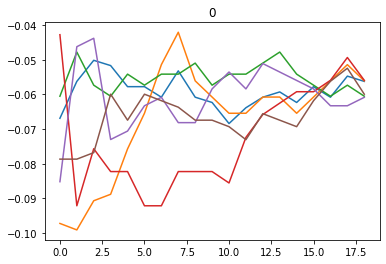

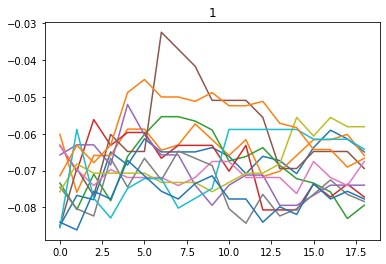

In [ ]:
for n in range(10):
    plt.title(n)
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == best_short_cluster[n]:
            plt.plot(X[i])
    plt.show()

In [ ]:
print()